<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

We will import the following libraries for the lab


In [2]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
pd.set_option('display.max_colwidth', None) #allow max colwidth
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

This function is to plot the confusion matrix.


In [3]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [4]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [5]:
data.head(100)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,2020-09-03,Falcon 9,15400.000000,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,2,B1060,-80.603956,28.608058,1
86,87,2020-10-06,Falcon 9,15400.000000,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,2,B1058,-80.603956,28.608058,1
87,88,2020-10-18,Falcon 9,15400.000000,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,5,B1051,-80.603956,28.608058,1
88,89,2020-10-24,Falcon 9,15400.000000,VLEO,CCAFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,2,B1060,-80.577366,28.561857,1


In [6]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [7]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [8]:
Y = data['Class'].to_numpy()
print(Y)

[0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]


## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [9]:
# students get this 
#define transforme
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [11]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [12]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [13]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_gscv = GridSearchCV(lr, parameters, cv=10)
logreg_cv = logreg_gscv.fit(X_train, Y_train)

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [14]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
logreg_cv_bs = logreg_cv.best_score_
print("accuracy :",logreg_cv_bs)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [15]:
logreg_cv_acc = logreg_cv.score(X_test, Y_test)
print("logreg_cv accurancy on the test data:", logreg_cv_acc)

logreg_cv accurancy on the test data: 0.8333333333333334


Lets look at the confusion matrix:


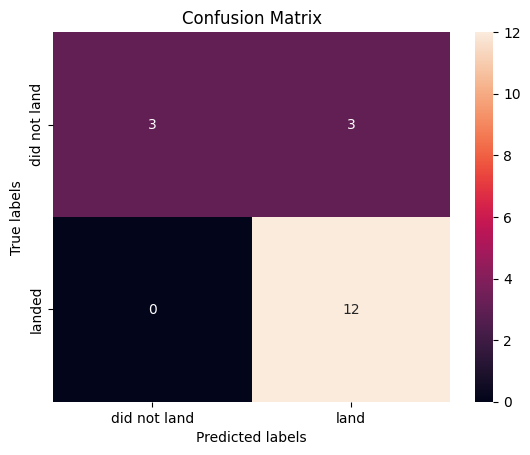

In [16]:
yhat=logreg_cv.predict(X_test)
logreg_F1 = f1_score(Y_test, yhat) 
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [17]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [18]:
svm_gscv = GridSearchCV(svm, parameters, cv=10)
svm_cv = svm_gscv.fit(X_train, Y_train)

In [19]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
svm_cv_bs = svm_cv.best_score_
print("accuracy :",svm_cv_bs)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [20]:
svm_cv_acc = svm_cv.score(X_test, Y_test)
print("svm_cv accurancy on the test data:", svm_cv_acc)

svm_cv accurancy on the test data: 0.8333333333333334


We can plot the confusion matrix


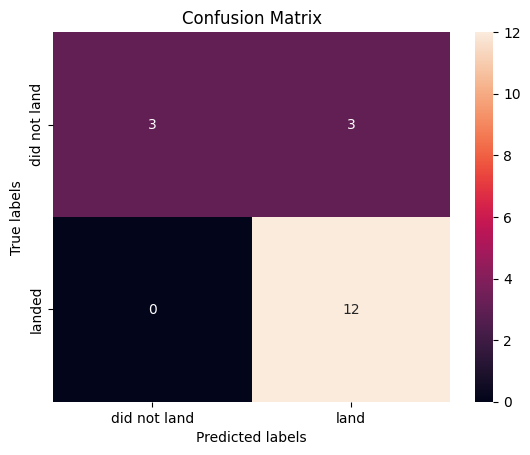

In [21]:
yhat=svm_cv.predict(X_test)
svm_F1 = f1_score(Y_test, yhat) 
plot_confusion_matrix(Y_test,yhat)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [22]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto','sqrt'], #'max_features='auto'' has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set 'max_features='sqrt''
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [30]:
tree_gscv = GridSearchCV(tree, parameters, cv=10)
tree_cv =tree_gscv.fit(X_train, Y_train)

In [31]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
tree_cv_bs = tree_cv.best_score_
print("accuracy :",tree_cv_bs)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.8875


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [32]:
tree_cv_acc = tree_cv.score(X_test, Y_test)
print("tree_cv accurancy on the test data:", tree_cv_acc)

tree_cv accurancy on the test data: 0.8333333333333334


We can plot the confusion matrix


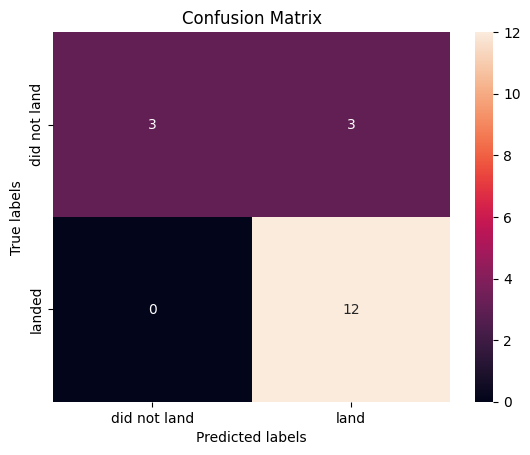

In [33]:
yhat = tree_cv.predict(X_test)
tree_F1 = f1_score(Y_test, yhat) 
plot_confusion_matrix(Y_test,yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [34]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [35]:
knn_gscv = GridSearchCV(KNN, parameters, cv=10)
knn_cv = knn_gscv.fit(X_train, Y_train)

In [36]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
knn_cv_bs = knn_cv.best_score_
print("accuracy :",knn_cv_bs)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [37]:
knn_cv_acc = knn_cv.score(X_test, Y_test)
print("knn_cv accurancy on the test data:", knn_cv_acc)

knn_cv accurancy on the test data: 0.8333333333333334


We can plot the confusion matrix


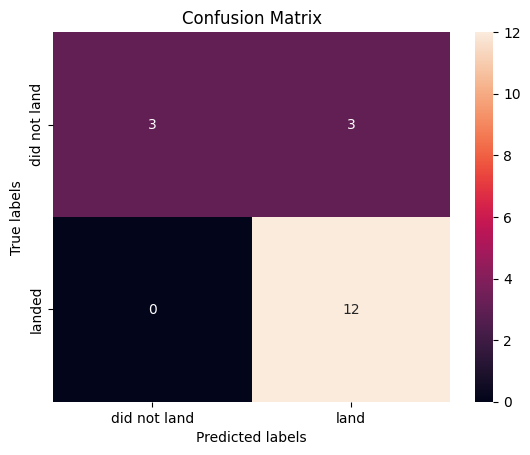

In [38]:
yhat = knn_cv.predict(X_test)
knn_F1 = f1_score(Y_test, yhat) 
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Find the method performs best:


In [43]:
scores_data = {'Model': ["Logistic_regression", "Support_vector_machine", "Decision_tree", "K_Nearest_Neighbors"],
               'F1_score': [logreg_F1, svm_F1, tree_F1, knn_F1],
               'Accurancy_score_on_test_data':[logreg_cv_acc, svm_cv_acc, tree_cv_acc, knn_cv_acc],
               'Best_score_accurancy': [logreg_cv_bs, svm_cv_bs, tree_cv_bs, knn_cv_bs],
               'Best_parameters': [logreg_cv.best_params_, svm_cv.best_params_, tree_cv.best_params_, knn_cv.best_params_]}
best_score_df = pd.DataFrame(scores_data)
best_score_df.sort_values(['Best_score_accurancy'], ascending=False, inplace=True)
best_score_df

,Model,F1_score,Accurancy_score_on_test_data,Best_score_accurancy,Best_parameters
2,Decision_tree,0.888889,0.833333,0.887500,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}"
3,K_Nearest_Neighbors,0.888889,0.833333,0.848214,"{'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}"
1,Support_vector_machine,0.888889,0.833333,0.848214,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}"
0,Logistic_regression,0.888889,0.833333,0.846429,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}"


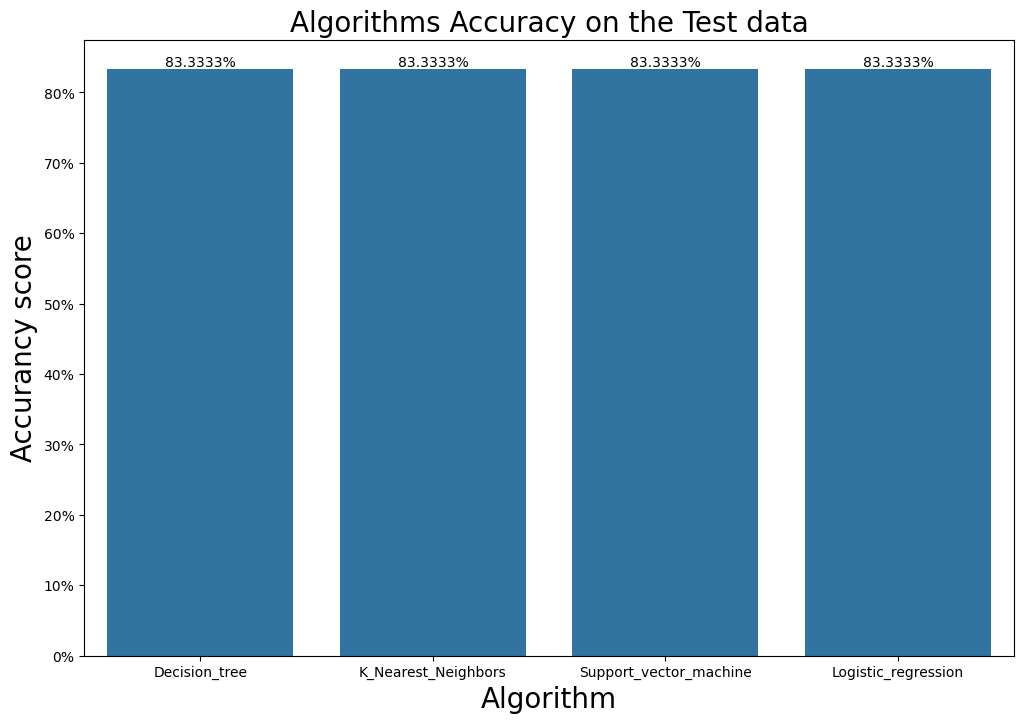

In [45]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x='Model', 
               y='Accurancy_score_on_test_data', 
               data=best_score_df)
plt.xlabel('Algorithm', fontsize=20)
plt.ylabel('Accurancy score', fontsize=20)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x*100)))
for p in ax.patches:
    ax.annotate('{:.4f}%'.format(p.get_height()*100), (p.get_x()+0.4, p.get_height()), 
                ha='center', va='bottom',color= 'black')
plt.title('Algorithms Accuracy on the Test data', fontsize=20)
plt.show()

If we use the Accurancy score on Test data to evaluate the algorithms, all of them got a score of 83.33%.

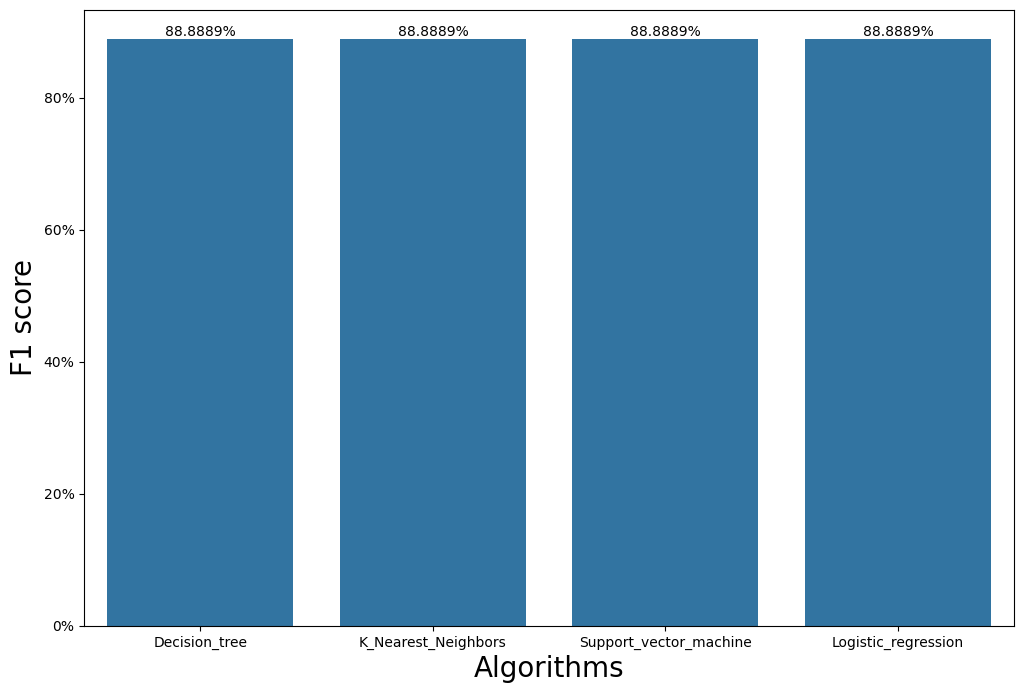

In [41]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x='Model', 
               y='F1_score', 
               data=best_score_df)
plt.xlabel('Algorithms', fontsize=20)
plt.ylabel('F1 score', fontsize=20)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x*100)))
for p in ax.patches:
    ax.annotate('{:.4f}%'.format(p.get_height()*100), (p.get_x()+0.4, p.get_height()), 
                ha='center', va='bottom',color= 'black')
#plt.title('Algorithms Accuracy on the Test data', fontsize=20)
plt.show()

Same thing if we base our decision on F1 score. All algorithms got 88,89%

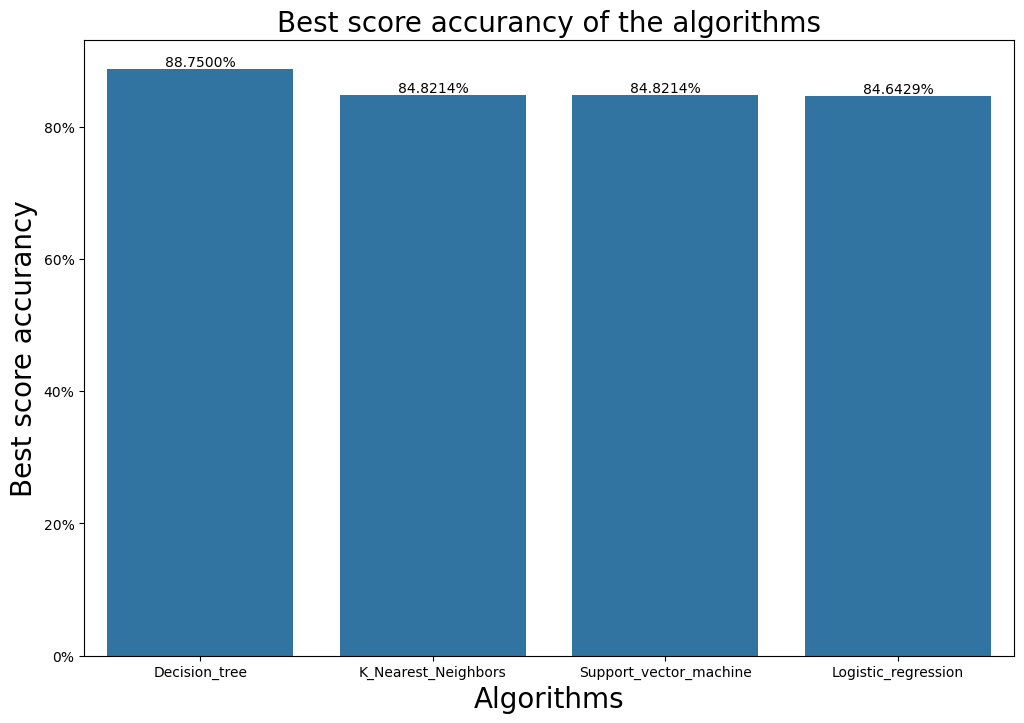

In [44]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x='Model', 
               y='Best_score_accurancy', 
               data=best_score_df)
plt.xlabel('Algorithms', fontsize=20)
plt.ylabel('Best score accurancy', fontsize=20)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x*100)))
for p in ax.patches:
    ax.annotate('{:.4f}%'.format(p.get_height()*100), (p.get_x()+0.4, p.get_height()), 
                ha='center', va='bottom',color= 'black')
plt.title('Best score accurancy of the algorithms', fontsize=20)
plt.show()

Based on the train accurancy, we can choose the decision tree algorithms with a 88,75% accurancy.
K-Nearest_Neighbors, SVM and Logistic Regression have got scores too with about 84%.

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2023-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
